In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 20
lead_time = 1
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'
gc_features = ['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 't2m', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

Date  wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
0  1/1/1979  5.531398           0.811961  186.687054    3.127880  1.009872   
1  2/1/1979  5.328020           0.688896  174.794571   18.541594  0.920831   
2  3/1/1979  5.432511           0.916124  190.741933   67.690429  0.983327   
3  4/1/1979  4.792836           1.272056  212.937925  156.223673  0.890723   
4  5/1/1979  4.819028           2.239776  253.690478  230.950833  1.201308   

   snowfall         sst         t2m  surface_pressure  sea_ice_extent  
0  0.892319  273.355237  250.388101        984.633032        15604191  
1  0.781347  273.121885  247.071202        983.980418        16378929  
2  0.855266  273.088099  252.954138        985.140468        16521089  
3  0.705203  273.126062  259.557456        989.314698        15561238  
4  0.688723  273.393551  269.375118        984.483658        14085613

In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[gc_features]
df.tail(len(df))

wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
Date                                                                        
1979-01-01  5.531398           0.811961  186.687054    3.127880  1.009872   
1979-02-01  5.328020           0.688896  174.794571   18.541594  0.920831   
1979-03-01  5.432511           0.916124  190.741933   67.690429  0.983327   
1979-04-01  4.792836           1.272056  212.937925  156.223673  0.890723   
1979-05-01  4.819028           2.239776  253.690478  230.950833  1.201308   
...              ...                ...         ...         ...       ...   
2021-04-01  5.383687           1.529497  225.171796  156.567743  1.159049   
2021-05-01  4.777020           2.451088  260.956781  229.604138  1.077705   
2021-06-01  4.771453           4.176458  294.931709  244.702852  1.585094   
2021-07-01  4.754014           5.193846  313.311345  196.774631  1.957911   
2021-08-01  4.635243           5.077386  313.003568  126.146891  2.046782   

            snowfall         t2m  surface_pressure  sea_ice_extent  
Date                                                                
1979-01-01  0.892319  250.388101        984.633032      15604191.0  
1979-02-01  0.781347  247.071202        983.980418      16378929.0  
1979-03-01  0.855266  252.954138        985.140468      16521089.0  
1979-04-01  0.705203  259.557456        989.314698      15561238.0  
1979-05-01  0.688723  269.375118        984.483658      14085613.0  
...              ...         ...               ...             ...  
2021-04-01  0.929777  263.146395        985.801841      13840000.0  
2021-05-01  0.575494  271.557464        985.606182      12660000.0  
2021-06-01  0.360146  278.360921        978.436682      10710000.0  
2021-07-01  0.248088  280.413695        978.293303       7690000.0  
2021-08-01  0.235519  279.556077        980.453507       5750000.0  

[512 rows x 9 columns]

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

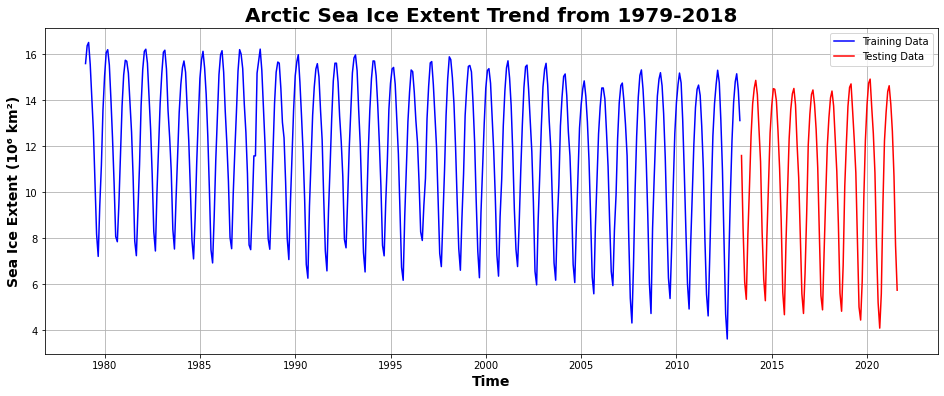

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            14400     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
5/6 [========================>.....] - ETA: 0s - loss: 0.2921 - mae: 0.4723 - mse: 0.2921

6/6 [==============================] - 17s 526ms/step - loss: 0.2706 - mae: 0.4474 - mse: 0.2706 - val_loss: 0.1318 - val_mae: 0.2601 - val_mse: 0.1318
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0747 - mae: 0.2263 - mse: 0.0747

6/6 [==============================] - 0s 60ms/step - loss: 0.0730 - mae: 0.2243 - mse: 0.0730 - val_loss: 0.0856 - val_mae: 0.2287 - val_mse: 0.0856
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0795 - mae: 0.2256 - mse: 0.0795

6/6 [==============================] - 0s 46ms/step - loss: 0.0818 - mae: 0.2283 - mse: 0.0818 - val_loss: 0.0807 - val_mae: 0.2377 - val_mse: 0.0807
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0744 - mae: 0.2362 - mse: 0.0744

6/6 [==============================] - 0s 47ms/step - loss: 0.0733 - mae: 0.2342 - mse: 0.0733 - val_loss: 0.0894 - val_mae: 0.2349 - val_mse: 0.0894
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0648 - mae: 0.2060 - mse: 0.0648

6/6 [==============================] - 0s 45ms/step - loss: 0.0661 - mae: 0.2097 - mse: 0.0661 - val_loss: 0.0774 - val_mae: 0.2421 - val_mse: 0.0774
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0685 - mae: 0.2281 - mse: 0.0685

6/6 [==============================] - 0s 48ms/step - loss: 0.0681 - mae: 0.2276 - mse: 0.0681 - val_loss: 0.0821 - val_mae: 0.2351 - val_mse: 0.0821
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0645 - mae: 0.2101 - mse: 0.0645

6/6 [==============================] - 0s 47ms/step - loss: 0.0629 - mae: 0.2071 - mse: 0.0629 - val_loss: 0.0874 - val_mae: 0.2343 - val_mse: 0.0874
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0575 - mae: 0.2077 - mse: 0.0575

6/6 [==============================] - 0s 45ms/step - loss: 0.0580 - mae: 0.2096 - mse: 0.0580 - val_loss: 0.0770 - val_mae: 0.2385 - val_mse: 0.0770
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0606 - mae: 0.2147 - mse: 0.0606

6/6 [==============================] - 0s 43ms/step - loss: 0.0616 - mae: 0.2158 - mse: 0.0616 - val_loss: 0.0773 - val_mae: 0.2288 - val_mse: 0.0773
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3218 - mae: 0.3100 - mse: 0.3218

6/6 [==============================] - 0s 45ms/step - loss: 0.2962 - mae: 0.2961 - mse: 0.2962 - val_loss: 0.0807 - val_mae: 0.2334 - val_mse: 0.0807
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0628 - mae: 0.2155 - mse: 0.0628

6/6 [==============================] - 0s 45ms/step - loss: 0.0627 - mae: 0.2154 - mse: 0.0627 - val_loss: 0.0956 - val_mae: 0.2347 - val_mse: 0.0956
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0673 - mae: 0.2179 - mse: 0.0673

6/6 [==============================] - 0s 45ms/step - loss: 0.0675 - mae: 0.2184 - mse: 0.0675 - val_loss: 0.0765 - val_mae: 0.2409 - val_mse: 0.0765
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0628 - mae: 0.2122 - mse: 0.0628

6/6 [==============================] - 0s 44ms/step - loss: 0.0638 - mae: 0.2130 - mse: 0.0638 - val_loss: 0.0874 - val_mae: 0.2336 - val_mse: 0.0874
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0625 - mae: 0.2127 - mse: 0.0625

6/6 [==============================] - 0s 46ms/step - loss: 0.0624 - mae: 0.2122 - mse: 0.0624 - val_loss: 0.0773 - val_mae: 0.2374 - val_mse: 0.0773
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0615 - mae: 0.2120 - mse: 0.0615

6/6 [==============================] - 0s 48ms/step - loss: 0.0612 - mae: 0.2122 - mse: 0.0612 - val_loss: 0.0825 - val_mae: 0.2325 - val_mse: 0.0825
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0578 - mae: 0.2048 - mse: 0.0578

6/6 [==============================] - 0s 46ms/step - loss: 0.0581 - mae: 0.2059 - mse: 0.0581 - val_loss: 0.0792 - val_mae: 0.2321 - val_mse: 0.0792
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0586 - mae: 0.2062 - mse: 0.0586

6/6 [==============================] - 0s 46ms/step - loss: 0.0591 - mae: 0.2077 - mse: 0.0591 - val_loss: 0.0731 - val_mae: 0.2377 - val_mse: 0.0731
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0625 - mae: 0.2170 - mse: 0.0625

6/6 [==============================] - 0s 44ms/step - loss: 0.0603 - mae: 0.2117 - mse: 0.0603 - val_loss: 0.0731 - val_mae: 0.2278 - val_mse: 0.0731
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0570 - mae: 0.2053 - mse: 0.0570

6/6 [==============================] - 0s 43ms/step - loss: 0.0570 - mae: 0.2058 - mse: 0.0570 - val_loss: 0.0681 - val_mae: 0.2199 - val_mse: 0.0681
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0564 - mae: 0.2011 - mse: 0.0564

6/6 [==============================] - 0s 45ms/step - loss: 0.0560 - mae: 0.2010 - mse: 0.0560 - val_loss: 0.0664 - val_mae: 0.2261 - val_mse: 0.0664
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0523 - mae: 0.1940 - mse: 0.0523

6/6 [==============================] - 0s 50ms/step - loss: 0.0542 - mae: 0.1961 - mse: 0.0542 - val_loss: 0.0586 - val_mae: 0.1997 - val_mse: 0.0586
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0434 - mae: 0.1823 - mse: 0.0434

6/6 [==============================] - 0s 49ms/step - loss: 0.0420 - mae: 0.1780 - mse: 0.0420 - val_loss: 0.0380 - val_mae: 0.1721 - val_mse: 0.0380
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0897 - mae: 0.2435 - mse: 0.0897

6/6 [==============================] - 0s 58ms/step - loss: 0.0867 - mae: 0.2405 - mse: 0.0867 - val_loss: 0.0796 - val_mae: 0.2530 - val_mse: 0.0796
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0659 - mae: 0.2218 - mse: 0.0659

6/6 [==============================] - 0s 54ms/step - loss: 0.0658 - mae: 0.2224 - mse: 0.0658 - val_loss: 0.0924 - val_mae: 0.2354 - val_mse: 0.0924
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0655 - mae: 0.2138 - mse: 0.0655

6/6 [==============================] - 0s 53ms/step - loss: 0.0654 - mae: 0.2142 - mse: 0.0654 - val_loss: 0.0789 - val_mae: 0.2378 - val_mse: 0.0789
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0625 - mae: 0.2147 - mse: 0.0625

6/6 [==============================] - 0s 48ms/step - loss: 0.0633 - mae: 0.2154 - mse: 0.0633 - val_loss: 0.0810 - val_mae: 0.2360 - val_mse: 0.0810
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0635 - mae: 0.2117 - mse: 0.0635

6/6 [==============================] - 0s 49ms/step - loss: 0.0622 - mae: 0.2106 - mse: 0.0622 - val_loss: 0.0835 - val_mae: 0.2349 - val_mse: 0.0835
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0565 - mae: 0.2010 - mse: 0.0565

6/6 [==============================] - 0s 50ms/step - loss: 0.0596 - mae: 0.2071 - mse: 0.0596 - val_loss: 0.0788 - val_mae: 0.2382 - val_mse: 0.0788
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0620 - mae: 0.2179 - mse: 0.0620

6/6 [==============================] - 0s 49ms/step - loss: 0.0625 - mae: 0.2190 - mse: 0.0625 - val_loss: 0.0817 - val_mae: 0.2355 - val_mse: 0.0817
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0613 - mae: 0.2108 - mse: 0.0613

6/6 [==============================] - 0s 45ms/step - loss: 0.0607 - mae: 0.2107 - mse: 0.0607 - val_loss: 0.0859 - val_mae: 0.2345 - val_mse: 0.0859
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0599 - mae: 0.2066 - mse: 0.0599

6/6 [==============================] - 0s 46ms/step - loss: 0.0606 - mae: 0.2093 - mse: 0.0606 - val_loss: 0.0780 - val_mae: 0.2389 - val_mse: 0.0780
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0617 - mae: 0.2180 - mse: 0.0617

6/6 [==============================] - 0s 46ms/step - loss: 0.0616 - mae: 0.2175 - mse: 0.0616 - val_loss: 0.0821 - val_mae: 0.2351 - val_mse: 0.0821
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0634 - mae: 0.2080 - mse: 0.0634

6/6 [==============================] - 0s 47ms/step - loss: 0.0630 - mae: 0.2079 - mse: 0.0630 - val_loss: 0.0809 - val_mae: 0.2356 - val_mse: 0.0809
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0580 - mae: 0.2094 - mse: 0.0580

6/6 [==============================] - 0s 46ms/step - loss: 0.0587 - mae: 0.2109 - mse: 0.0587 - val_loss: 0.0781 - val_mae: 0.2381 - val_mse: 0.0781
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0585 - mae: 0.2103 - mse: 0.0585

6/6 [==============================] - 0s 45ms/step - loss: 0.0576 - mae: 0.2084 - mse: 0.0576 - val_loss: 0.0848 - val_mae: 0.2339 - val_mse: 0.0848
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0579 - mae: 0.2027 - mse: 0.0579

6/6 [==============================] - 0s 46ms/step - loss: 0.0586 - mae: 0.2039 - mse: 0.0586 - val_loss: 0.0796 - val_mae: 0.2355 - val_mse: 0.0796
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0558 - mae: 0.2036 - mse: 0.0558

6/6 [==============================] - 0s 46ms/step - loss: 0.0568 - mae: 0.2059 - mse: 0.0568 - val_loss: 0.0781 - val_mae: 0.2361 - val_mse: 0.0781
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0593 - mae: 0.2107 - mse: 0.0593

6/6 [==============================] - 0s 47ms/step - loss: 0.0580 - mae: 0.2082 - mse: 0.0580 - val_loss: 0.0810 - val_mae: 0.2325 - val_mse: 0.0810
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0598 - mae: 0.2118 - mse: 0.0598

6/6 [==============================] - 0s 47ms/step - loss: 0.0580 - mae: 0.2087 - mse: 0.0580 - val_loss: 0.0793 - val_mae: 0.2301 - val_mse: 0.0793
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0552 - mae: 0.2021 - mse: 0.0552

6/6 [==============================] - 0s 45ms/step - loss: 0.0565 - mae: 0.2036 - mse: 0.0565 - val_loss: 0.0778 - val_mae: 0.2236 - val_mse: 0.0778
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0528 - mae: 0.1939 - mse: 0.0528

6/6 [==============================] - 0s 45ms/step - loss: 0.0536 - mae: 0.1958 - mse: 0.0536 - val_loss: 0.0751 - val_mae: 0.2472 - val_mse: 0.0751
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0592 - mae: 0.2026 - mse: 0.0592

6/6 [==============================] - 0s 47ms/step - loss: 0.0572 - mae: 0.1986 - mse: 0.0572 - val_loss: 0.0688 - val_mae: 0.2207 - val_mse: 0.0688
Epoch 43/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0452 - mae: 0.1840 - mse: 0.0452

6/6 [==============================] - 0s 46ms/step - loss: 0.0448 - mae: 0.1829 - mse: 0.0448 - val_loss: 0.0794 - val_mae: 0.2050 - val_mse: 0.0794
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0378 - mae: 0.1558 - mse: 0.0378

6/6 [==============================] - 0s 48ms/step - loss: 0.0371 - mae: 0.1538 - mse: 0.0371 - val_loss: 0.0384 - val_mae: 0.1399 - val_mse: 0.0384
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0279 - mae: 0.1344 - mse: 0.0279

6/6 [==============================] - 0s 47ms/step - loss: 0.0268 - mae: 0.1316 - mse: 0.0268 - val_loss: 0.0166 - val_mae: 0.0986 - val_mse: 0.0166
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0173 - mae: 0.1063 - mse: 0.0173

6/6 [==============================] - 0s 48ms/step - loss: 0.0190 - mae: 0.1111 - mse: 0.0190 - val_loss: 0.0397 - val_mae: 0.1726 - val_mse: 0.0397
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0185 - mae: 0.1087 - mse: 0.0185

6/6 [==============================] - 0s 45ms/step - loss: 0.0174 - mae: 0.1047 - mse: 0.0174 - val_loss: 0.0406 - val_mae: 0.1613 - val_mse: 0.0406
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0148 - mae: 0.0958 - mse: 0.0148

6/6 [==============================] - 0s 47ms/step - loss: 0.0148 - mae: 0.0949 - mse: 0.0148 - val_loss: 0.0259 - val_mae: 0.1326 - val_mse: 0.0259
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0103 - mae: 0.0789 - mse: 0.0103

6/6 [==============================] - 0s 49ms/step - loss: 0.0102 - mae: 0.0788 - mse: 0.0102 - val_loss: 0.0177 - val_mae: 0.0969 - val_mse: 0.0177
Epoch 50/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0102 - mae: 0.0806 - mse: 0.0102

6/6 [==============================] - 0s 46ms/step - loss: 0.0107 - mae: 0.0819 - mse: 0.0107 - val_loss: 0.0129 - val_mae: 0.0767 - val_mse: 0.0129
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0105 - mae: 0.0805 - mse: 0.0105

6/6 [==============================] - 0s 43ms/step - loss: 0.0101 - mae: 0.0792 - mse: 0.0101 - val_loss: 0.0225 - val_mae: 0.1191 - val_mse: 0.0225
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0099 - mae: 0.0795 - mse: 0.0099

6/6 [==============================] - 0s 44ms/step - loss: 0.0098 - mae: 0.0791 - mse: 0.0098 - val_loss: 0.0188 - val_mae: 0.1052 - val_mse: 0.0188
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0086 - mae: 0.0731 - mse: 0.0086

6/6 [==============================] - 0s 44ms/step - loss: 0.0090 - mae: 0.0746 - mse: 0.0090 - val_loss: 0.0121 - val_mae: 0.0838 - val_mse: 0.0121
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0094 - mae: 0.0752 - mse: 0.0094

6/6 [==============================] - 0s 46ms/step - loss: 0.0091 - mae: 0.0744 - mse: 0.0091 - val_loss: 0.0206 - val_mae: 0.1136 - val_mse: 0.0206
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0089 - mae: 0.0743 - mse: 0.0089

6/6 [==============================] - 0s 45ms/step - loss: 0.0090 - mae: 0.0753 - mse: 0.0090 - val_loss: 0.0241 - val_mae: 0.1380 - val_mse: 0.0241
Epoch 56/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0088 - mae: 0.0769 - mse: 0.0088

6/6 [==============================] - 0s 49ms/step - loss: 0.0088 - mae: 0.0764 - mse: 0.0088 - val_loss: 0.0253 - val_mae: 0.1318 - val_mse: 0.0253
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0093 - mae: 0.0739 - mse: 0.0093

6/6 [==============================] - 0s 46ms/step - loss: 0.0091 - mae: 0.0737 - mse: 0.0091 - val_loss: 0.0153 - val_mae: 0.1016 - val_mse: 0.0153
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0089 - mae: 0.0734 - mse: 0.0089

6/6 [==============================] - 0s 47ms/step - loss: 0.0087 - mae: 0.0722 - mse: 0.0087 - val_loss: 0.0243 - val_mae: 0.1325 - val_mse: 0.0243
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0105 - mae: 0.0810 - mse: 0.0105

6/6 [==============================] - 0s 44ms/step - loss: 0.0105 - mae: 0.0807 - mse: 0.0105 - val_loss: 0.0157 - val_mae: 0.1007 - val_mse: 0.0157
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0089 - mae: 0.0757 - mse: 0.0089

6/6 [==============================] - 0s 44ms/step - loss: 0.0089 - mae: 0.0750 - mse: 0.0089 - val_loss: 0.0134 - val_mae: 0.0904 - val_mse: 0.0134
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0093 - mae: 0.0756 - mse: 0.0093

6/6 [==============================] - 0s 48ms/step - loss: 0.0090 - mae: 0.0739 - mse: 0.0090 - val_loss: 0.0154 - val_mae: 0.1000 - val_mse: 0.0154
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0072 - mae: 0.0682 - mse: 0.0072

6/6 [==============================] - 0s 46ms/step - loss: 0.0074 - mae: 0.0690 - mse: 0.0074 - val_loss: 0.0129 - val_mae: 0.0894 - val_mse: 0.0129
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0075 - mae: 0.0681 - mse: 0.0075

6/6 [==============================] - 0s 48ms/step - loss: 0.0076 - mae: 0.0684 - mse: 0.0076 - val_loss: 0.0172 - val_mae: 0.1093 - val_mse: 0.0172
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0076 - mae: 0.0686 - mse: 0.0076

6/6 [==============================] - 0s 48ms/step - loss: 0.0075 - mae: 0.0685 - mse: 0.0075 - val_loss: 0.0125 - val_mae: 0.0881 - val_mse: 0.0125
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0080 - mae: 0.0697 - mse: 0.0080

6/6 [==============================] - 0s 47ms/step - loss: 0.0083 - mae: 0.0710 - mse: 0.0083 - val_loss: 0.0134 - val_mae: 0.0858 - val_mse: 0.0134
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0072 - mae: 0.0645 - mse: 0.0072

6/6 [==============================] - 0s 47ms/step - loss: 0.0073 - mae: 0.0652 - mse: 0.0073 - val_loss: 0.0099 - val_mae: 0.0748 - val_mse: 0.0099
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0076 - mae: 0.0680 - mse: 0.0076

6/6 [==============================] - 0s 48ms/step - loss: 0.0074 - mae: 0.0676 - mse: 0.0074 - val_loss: 0.0096 - val_mae: 0.0672 - val_mse: 0.0096
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0646 - mse: 0.0064

6/6 [==============================] - 0s 47ms/step - loss: 0.0065 - mae: 0.0648 - mse: 0.0065 - val_loss: 0.0158 - val_mae: 0.0942 - val_mse: 0.0158
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0632 - mse: 0.0064

6/6 [==============================] - 0s 47ms/step - loss: 0.0064 - mae: 0.0634 - mse: 0.0064 - val_loss: 0.0118 - val_mae: 0.0913 - val_mse: 0.0118
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0634 - mse: 0.0062

6/6 [==============================] - 0s 45ms/step - loss: 0.0063 - mae: 0.0635 - mse: 0.0063 - val_loss: 0.0098 - val_mae: 0.0693 - val_mse: 0.0098
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0066 - mae: 0.0648 - mse: 0.0066

6/6 [==============================] - 0s 47ms/step - loss: 0.0067 - mae: 0.0654 - mse: 0.0067 - val_loss: 0.0104 - val_mae: 0.0733 - val_mse: 0.0104
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0069 - mae: 0.0666 - mse: 0.0069

6/6 [==============================] - 0s 47ms/step - loss: 0.0070 - mae: 0.0668 - mse: 0.0070 - val_loss: 0.0127 - val_mae: 0.0994 - val_mse: 0.0127
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0066 - mae: 0.0634 - mse: 0.0066

6/6 [==============================] - 0s 47ms/step - loss: 0.0070 - mae: 0.0653 - mse: 0.0070 - val_loss: 0.0095 - val_mae: 0.0791 - val_mse: 0.0095
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0070 - mae: 0.0685 - mse: 0.0070

6/6 [==============================] - 0s 44ms/step - loss: 0.0067 - mae: 0.0666 - mse: 0.0067 - val_loss: 0.0247 - val_mae: 0.1291 - val_mse: 0.0247
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0072 - mae: 0.0679 - mse: 0.0072

6/6 [==============================] - 0s 48ms/step - loss: 0.0071 - mae: 0.0676 - mse: 0.0071 - val_loss: 0.0094 - val_mae: 0.0785 - val_mse: 0.0094
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0061 - mae: 0.0618 - mse: 0.0061

6/6 [==============================] - 0s 47ms/step - loss: 0.0060 - mae: 0.0615 - mse: 0.0060 - val_loss: 0.0158 - val_mae: 0.0998 - val_mse: 0.0158
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0068 - mae: 0.0645 - mse: 0.0068

6/6 [==============================] - 0s 49ms/step - loss: 0.0066 - mae: 0.0633 - mse: 0.0066 - val_loss: 0.0088 - val_mae: 0.0813 - val_mse: 0.0088
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0068 - mae: 0.0637 - mse: 0.0068

6/6 [==============================] - 0s 47ms/step - loss: 0.0066 - mae: 0.0628 - mse: 0.0066 - val_loss: 0.0101 - val_mae: 0.0731 - val_mse: 0.0101
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0061 - mae: 0.0610 - mse: 0.0061

6/6 [==============================] - 0s 47ms/step - loss: 0.0060 - mae: 0.0604 - mse: 0.0060 - val_loss: 0.0099 - val_mae: 0.0827 - val_mse: 0.0099
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0058 - mae: 0.0621 - mse: 0.0058

6/6 [==============================] - 0s 47ms/step - loss: 0.0061 - mae: 0.0634 - mse: 0.0061 - val_loss: 0.0122 - val_mae: 0.0854 - val_mse: 0.0122
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0563 - mse: 0.0051

6/6 [==============================] - 0s 47ms/step - loss: 0.0052 - mae: 0.0565 - mse: 0.0052 - val_loss: 0.0099 - val_mae: 0.0867 - val_mse: 0.0099
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0056 - mae: 0.0606 - mse: 0.0056

6/6 [==============================] - 0s 48ms/step - loss: 0.0055 - mae: 0.0600 - mse: 0.0055 - val_loss: 0.0172 - val_mae: 0.1047 - val_mse: 0.0172
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0642 - mse: 0.0064

6/6 [==============================] - 0s 47ms/step - loss: 0.0066 - mae: 0.0654 - mse: 0.0066 - val_loss: 0.0213 - val_mae: 0.1247 - val_mse: 0.0213
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0061 - mae: 0.0614 - mse: 0.0061

6/6 [==============================] - 0s 47ms/step - loss: 0.0062 - mae: 0.0620 - mse: 0.0062 - val_loss: 0.0153 - val_mae: 0.1073 - val_mse: 0.0153
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0058 - mae: 0.0592 - mse: 0.0058

6/6 [==============================] - 0s 49ms/step - loss: 0.0058 - mae: 0.0596 - mse: 0.0058 - val_loss: 0.0092 - val_mae: 0.0790 - val_mse: 0.0092
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0540 - mse: 0.0048

6/6 [==============================] - 0s 47ms/step - loss: 0.0048 - mae: 0.0541 - mse: 0.0048 - val_loss: 0.0093 - val_mae: 0.0765 - val_mse: 0.0093
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0572 - mse: 0.0051

6/6 [==============================] - 0s 48ms/step - loss: 0.0051 - mae: 0.0573 - mse: 0.0051 - val_loss: 0.0077 - val_mae: 0.0686 - val_mse: 0.0077
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0044 - mae: 0.0514 - mse: 0.0044

6/6 [==============================] - 0s 47ms/step - loss: 0.0046 - mae: 0.0532 - mse: 0.0046 - val_loss: 0.0095 - val_mae: 0.0794 - val_mse: 0.0095
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0560 - mse: 0.0049

6/6 [==============================] - 0s 48ms/step - loss: 0.0049 - mae: 0.0564 - mse: 0.0049 - val_loss: 0.0092 - val_mae: 0.0860 - val_mse: 0.0092
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0053 - mae: 0.0571 - mse: 0.0053

6/6 [==============================] - 0s 47ms/step - loss: 0.0051 - mae: 0.0560 - mse: 0.0051 - val_loss: 0.0151 - val_mae: 0.1103 - val_mse: 0.0151
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0539 - mse: 0.0049

6/6 [==============================] - 0s 47ms/step - loss: 0.0048 - mae: 0.0534 - mse: 0.0048 - val_loss: 0.0116 - val_mae: 0.0949 - val_mse: 0.0116
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0543 - mse: 0.0048

6/6 [==============================] - 0s 47ms/step - loss: 0.0049 - mae: 0.0548 - mse: 0.0049 - val_loss: 0.0070 - val_mae: 0.0650 - val_mse: 0.0070
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0570 - mse: 0.0051

6/6 [==============================] - 0s 49ms/step - loss: 0.0050 - mae: 0.0565 - mse: 0.0050 - val_loss: 0.0059 - val_mae: 0.0620 - val_mse: 0.0059
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0058 - mae: 0.0598 - mse: 0.0058

6/6 [==============================] - 0s 47ms/step - loss: 0.0057 - mae: 0.0594 - mse: 0.0057 - val_loss: 0.0104 - val_mae: 0.0832 - val_mse: 0.0104
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0513 - mse: 0.0043

6/6 [==============================] - 0s 46ms/step - loss: 0.0042 - mae: 0.0509 - mse: 0.0042 - val_loss: 0.0108 - val_mae: 0.0926 - val_mse: 0.0108
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0523 - mse: 0.0042

6/6 [==============================] - 0s 50ms/step - loss: 0.0041 - mae: 0.0522 - mse: 0.0041 - val_loss: 0.0070 - val_mae: 0.0633 - val_mse: 0.0070
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0519 - mse: 0.0043

6/6 [==============================] - 0s 46ms/step - loss: 0.0043 - mae: 0.0522 - mse: 0.0043 - val_loss: 0.0090 - val_mae: 0.0777 - val_mse: 0.0090
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0045 - mae: 0.0551 - mse: 0.0045

6/6 [==============================] - 0s 45ms/step - loss: 0.0047 - mae: 0.0562 - mse: 0.0047 - val_loss: 0.0111 - val_mae: 0.0874 - val_mse: 0.0111
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0046 - mae: 0.0536 - mse: 0.0046

6/6 [==============================] - 0s 46ms/step - loss: 0.0046 - mae: 0.0535 - mse: 0.0046 - val_loss: 0.0071 - val_mae: 0.0700 - val_mse: 0.0071
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0514 - mse: 0.0043

6/6 [==============================] - 0s 48ms/step - loss: 0.0043 - mae: 0.0520 - mse: 0.0043 - val_loss: 0.0127 - val_mae: 0.0995 - val_mse: 0.0127


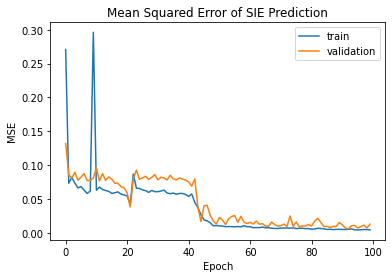

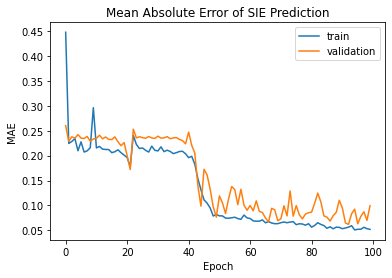

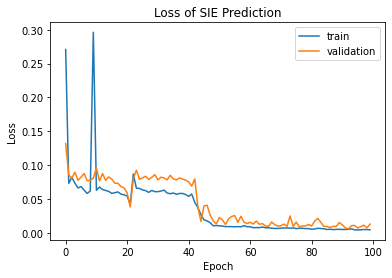

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 20ms/step


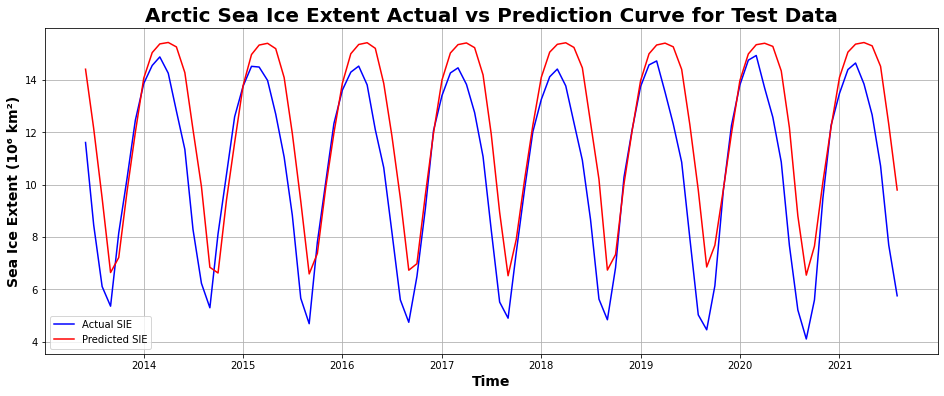

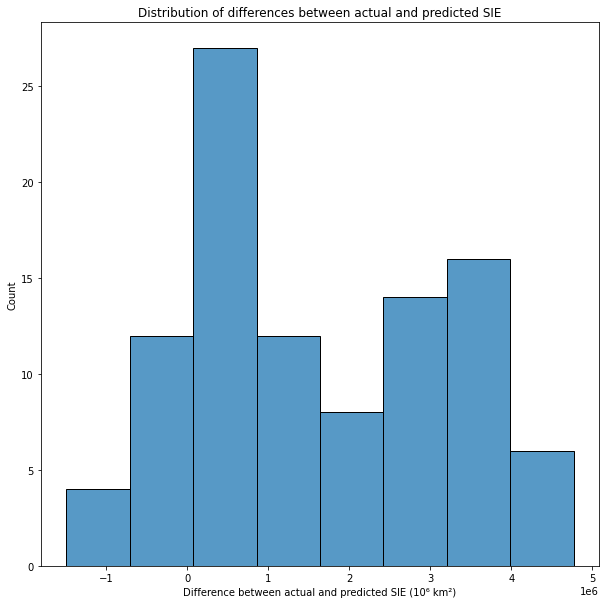

MSE :  5120917963539.086 (10⁶ km²)
MSPE : 9.727 %
RMSE :  2262944.5339068933 (10⁶ km²)
RMSPE : 31.188 %
MAE :  1781064.5353535353 (10⁶ km²)
MAPE :  15.839 %
R2 :  44.228


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass